In [6]:
# pip install scikit-survival optuna

In [7]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
df = pd.read_csv('data/processed_pancan_pca.csv')

print(f"Data Shape: {df.shape}")

Data Shape: (10952, 3399)


In [9]:
# ==========================================
# 2. PREPARE FEATURES (X) AND TARGET (y)
# ==========================================
# Drop the ID and Targets from the input features
X = df.drop(columns=['sample', 'OS', 'OS.time'])

# Construct the structured target array required by scikit-survival
# Format: List of tuples (Status: bool, Time: float)
y = np.array(
    list(zip(df['OS'].astype(bool), df['OS.time'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

Features (X): (10952, 3396)
Target (y): (10952,)


In [10]:
# SPLIT TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['Status']
)

In [11]:
# Naive check to ensure stratification worked
# n_estimators=100: Create 100 trees
# min_samples_leaf=15: Prevents overfitting by ensuring leaf nodes aren't too small
rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rsf.fit(X_train, y_train)
print("Training Complete!")

Training Complete!


In [12]:
# ==========================================
# 5. EVALUATION
# ==========================================
# Predict risk scores (higher score = lower survival probability)
print("Evaluating on Test Set...")
scores = rsf.predict(X_test)

# Calculate C-Index
c_index = concordance_index_censored(
    y_test['Status'], 
    y_test['Survival_in_days'], 
    scores
)[0]

print(f"\n==========================================")
print(f"RSF C-INDEX: {c_index:.4f}")
print(f"==========================================")
# Interpretation:
# 0.5 = Random Guessing
# 0.7 = Good model
# 0.8+ = Excellent model

# ==========================================
# 6. FEATURE IMPORTANCE
# ==========================================
# Check permutation importance (or just simple feature importance from trees)
# Note: Permutation importance is more accurate but slow. 
# We'll use the basic visualization here.

importances = pd.Series(
    data=0, # Placeholder (RSF doesn't have a simple .feature_importances_ attribute like sklearn)
    index=X.columns
)

# Since sksurv RSF doesn't expose simple Gini importance, 
# we often look at how clinical features vs PCA features perform.
# (Calculating exact importance for 3000 features is computationally heavy).

print("\nModel trained successfully. To optimize performance:")
print("1. Increase n_estimators (e.g., to 1000)")
print("2. Tune min_samples_leaf (smaller = more complex trees)")

Evaluating on Test Set...

RSF C-INDEX: 0.7120

Model trained successfully. To optimize performance:
1. Increase n_estimators (e.g., to 1000)
2. Tune min_samples_leaf (smaller = more complex trees)


In [13]:
def objective(trial):
    """
    Optuna optimization function. 
    It defines the search space, trains the model, and returns the C-Index.
    """
    
    # --- A. Define Hyperparameter Search Space ---
    params = {
        # Number of trees: More is better but slower. 100-500 is a good range.
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=50),
        
        # Depth: Controls how complex each tree can get. 
        # Too deep = Overfitting, Too shallow = Underfitting.
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        
        # Min samples to split: Higher values prevent the tree from learning noise.
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 60),
        
        # Min samples in leaf: Guarantees a minimum cluster size at the end.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 30),
        
        # Max Features: How many features to check at each split.
        # 'sqrt' is standard, 'log2' is faster.
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }
    
    # --- B. Train Model ---
    rsf = RandomSurvivalForest(
        **params,
        n_jobs=-1,        # Use all CPU cores
        random_state=42,  # Deterministic results for this trial
        verbose=0         # Silence the training logs
    )
    
    rsf.fit(X_train, y_train)
    
    # --- C. Evaluate ---
    # We evaluate on the Test set here for speed, 
    # but in a rigorous production setting, you would use Cross-Validation inside the objective.
    scores = rsf.predict(X_test)
    c_index = concordance_index_censored(
        y_test['Status'], 
        y_test['Survival_in_days'], 
        scores
    )[0]
    
    return c_index

In [14]:
print("Starting Optuna study...")
# direction='maximize' because higher C-Index is better
study = optuna.create_study(direction='maximize', study_name="RSF_Optimization")

# n_trials=20: Runs 20 different combinations. 
# Increase to 50 or 100 if you have a powerful server.
study.optimize(objective, n_trials=20)

print("\n==========================================")
print(f"Best C-Index Found: {study.best_value:.4f}")
print("Best Parameters:")
print(study.best_params)
print("==========================================")

[I 2026-01-13 15:36:53,126] A new study created in memory with name: RSF_Optimization


Starting Optuna study...


[I 2026-01-13 15:49:53,751] Trial 0 finished with value: 0.7246525965147786 and parameters: {'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 24, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7246525965147786.
[I 2026-01-13 15:53:39,362] Trial 1 finished with value: 0.7258023218236508 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 41, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7258023218236508.
[I 2026-01-13 16:15:51,380] Trial 2 finished with value: 0.7223282869714371 and parameters: {'n_estimators': 300, 'max_depth': 14, 'min_samples_split': 37, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7258023218236508.
[I 2026-01-13 16:17:11,666] Trial 3 finished with value: 0.6468130857384344 and parameters: {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 28, 'max_features': 'log2'}. Best is trial 1 with value: 0.725802321


Best C-Index Found: 0.7328
Best Parameters:
{'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 52, 'min_samples_leaf': 5, 'max_features': 'sqrt'}


/var/folders/3b/jd8k5j055rx3c991jlh5x05h0000gn/T/ipykernel_97086/4284752233.py:4: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


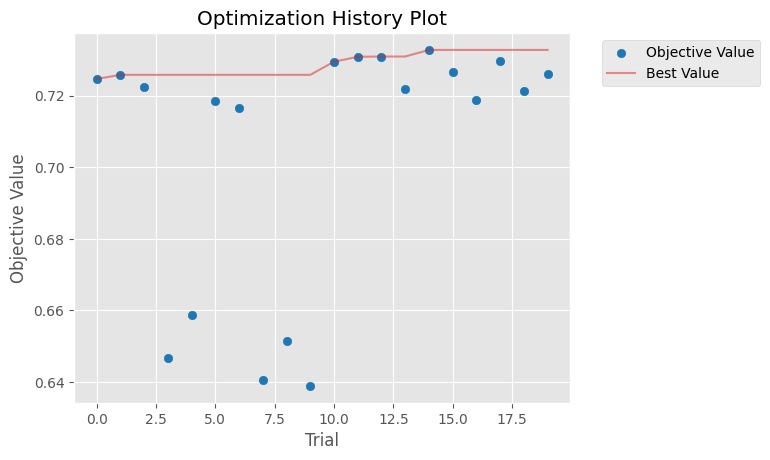

/var/folders/3b/jd8k5j055rx3c991jlh5x05h0000gn/T/ipykernel_97086/4284752233.py:8: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


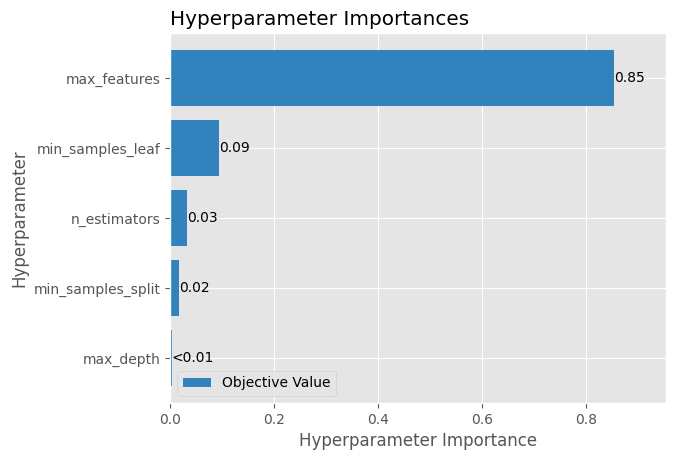

In [21]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

# 1. Shows if the model is improving over time
plot_optimization_history(study)
plt.show()  

# 2. Shows which parameter had the biggest impact
plot_param_importances(study)
plt.show()